In [1]:
import pandas as pd
from cleaning import create_demand
import pyomo.environ as pyo
import pyomo
import random

# Data import

In [2]:
nodes = pd.read_pickle("../../data/original/nodes.pkl")
channels = pd.read_pickle("../../data/original/channels.pkl")

In [3]:
channels["base_fee"] = channels.loc[:, "base_fee"].apply(lambda x: random.uniform(0,100)) # if x==0 else x)
channels["rate_fee"] = channels.loc[:, "rate_fee"].apply(lambda x: random.uniform(0.001,0.1)) # if x==0 else x)

## Modeling

In [4]:
pyomo.common.timing.report_timing()

In [5]:
# Multiplication to set the same base unit for all computations
channels["capacity"] = channels["capacity"] * 1000000
channels["base_fee"] = channels["base_fee"] * 1000000

In [6]:
model = pyo.ConcreteModel(name="Min cost flow problem")
model.NODES = pyo.Set(initialize=nodes.index)
model.CHANNELS = pyo.Set(initialize=[(channels.loc[i, "node1_pub"], channels.loc[i, "node2_pub"]) for i in channels.index])

           0 seconds to construct Block ConcreteModel; 1 index total
        0.03 seconds to construct Set NODES; 1 index total
        0.20 seconds to construct Set CHANNELS; 1 index total


In [7]:
transaction_amount = 100000
nodes = create_demand(nodes, transaction_amount,
                      source="02b4098c3116124c0c4105295d3d2e65927d46e98e248d84cb6119da57e4ae31e3",destination="0202f00d5f5c91a3c79113851b162c2b75f2cbd9fb2378fb4a4ce92d5ba1e63e08")

Transaction of 100000 sats.
Sender: VeniceForever
Receiver: ShatSat412.


In [8]:
model.x = pyo.Var(model.CHANNELS, domain=pyo.Binary)
model.a = pyo.Var(model.CHANNELS, domain=pyo.NonNegativeReals, bounds=(0, max(nodes["demand"])))

        0.12 seconds to construct Var x; 89898 indices total
        0.14 seconds to construct Var a; 89898 indices total


In [9]:
channels.reset_index(inplace=True)
channels.set_index(["node1_pub", "node2_pub"], inplace=True)
channels.sort_index(inplace=True)

### Objective function

$$
min \sum_{} ^{} amount_i \times feerate_{i} + x_{i} \times basefee_{i}
$$

In [10]:
#def objective_function(model: pyo.ConcreteModel):
#    return sum(model.a[i] * channels.loc[i, "rate_fee"] for i in model.CHANNELS) + sum(model.x[i] * channels.loc[i, "base_fee"] for i in model.CHANNELS)

def objective_function(model: pyo.ConcreteModel):
    return sum(model.a[i] * channels.loc[i, "rate_fee"] + model.x[i] * channels.loc[i, "base_fee"] for i in model.CHANNELS)

model.totalCost = pyo.Objective(rule=objective_function(model), sense=pyo.minimize)

           0 seconds to construct Objective totalCost; 1 index total


### Constraints

#### Symmetric channel flow rule

This constraint enforces the symmetry between the number of channel incoming and outgoing from an intermediary node (excluding source and destination nodes)

$$
\sum_{(i,n) \in E} x_{i,n} = \sum_{(n,j) \in E} x_{n,j} \text{ } \forall n \in V \bigwedge i \notin \{n, s, d\}
$$

where $s$ is the source node, with a negative demand and $d$ is the destination node, with positive demand.

In [11]:
s = nodes[nodes["demand"] < 0].index.values
d = nodes[nodes["demand"] > 0].index.values
intermediaries = [(i, j) for i, j in channels.index if i != s and j != d]

In [12]:
def number_channels_rule(model: pyo.ConcreteModel, n):
    incoming = [model.x[(i, j)] for i, j in intermediaries if j == n]
    outgoing = [model.x[(i, j)] for i, j in intermediaries if i == n]
    return sum(incoming) == sum(outgoing)

model.NumberChannelsConstraint = pyo.Constraint(model.NODES, rule=number_channels_rule, name="Number channels constraint")

       55.44 seconds to construct Constraint NumberChannelsConstraint; 11984 indices total


#### Capacity constraint

$$amount_{i,j} \le capacity_{i,j} \times x_{i,j} \text{ } \forall (i,j) \in E$$

In [13]:
def capacity_constraint(model: pyo.ConcreteModel, a, b):
    return model.a[(a, b)] <= channels.loc[(a, b), "capacity"] * model.x[(a, b)]

model.CapacityConstraint = pyo.Constraint(model.CHANNELS, rule=capacity_constraint, name="Capacity constraint")

        5.91 seconds to construct Constraint CapacityConstraint; 89898 indices total


#### Flow balance constraint

$$\sum_{(s,i) \in E} amount_{s,i} - \sum_{(i,t) \in E} amount_{i,d} = b_i \text{ } \forall i \in V$$

where $s$ is the source node, $d$ is the destination node, $i$ is every intermediary node


In [14]:
channels.reset_index(inplace=True)
channels.set_index("channel_id", inplace=True)

def flow_balance_constraint(model: pyo.ConcreteModel, n: str):
    InFlow = sum(model.a[(channels.loc[a, "node1_pub"], channels.loc[a, "node2_pub"])] for a in nodes.loc[n, 'incoming_channels'])
    OutFlow = sum(model.a[(channels.loc[a, "node1_pub"], channels.loc[a, "node2_pub"])] for a in nodes.loc[n, 'outgoing_channels'])
    return  OutFlow + nodes.loc[n, "demand"] == InFlow

model.FlowBalanceConstraint = pyo.Constraint(model.NODES, rule=flow_balance_constraint, name="Flow balance constrain")

channels.reset_index(inplace=True)
channels.set_index(["node1_pub", "node2_pub"], inplace=True)
channels.sort_index(inplace=True) 

        3.49 seconds to construct Constraint FlowBalanceConstraint; 11984 indices total


## Solving the model

In [15]:
#from pyomo.common.tempfiles import TempfileManager
#TempfileManager.tempdir = "/home/filippo/repositories/LN-pathfinding"

In [16]:
opt = pyo.SolverFactory('cbc')
#opt = pyo.SolverFactory('cplex_direct')
results = opt.solve(model, tee=True, keepfiles=True)

if (results.solver.status == pyo.SolverStatus.ok) and (results.solver.termination_condition == pyo.TerminationCondition.optimal):
    print('\nOptimal solution found')
elif results.solver.termination_condition == pyo.TerminationCondition.feasible:
    print('\nFeasible but not proven optimal solution found')
elif results.solver.termination_condition == pyo.TerminationCondition.infeasible:
    raise Exception("The model is infeasible")
else:
    print('\nSolver Status: ',  results.solver.status)
    raise Exception(results.solver.status)

print('\nObject function value = ', model.Objective())


           0 seconds to construct Var ONE_VAR_CONSTANT; 1 index total
      [    2.48] Generated LP representation
Solver log file: '/tmp/tmpo9t4h4d2.cbc.log'
Solver solution file: '/tmp/tmpo74bn6g_.pyomo.soln'
Solver problem files: ('/tmp/tmpo74bn6g_.pyomo.lp',)
Welcome to the CBC MILP Solver 
Version: 2.10.8 
Build Date: May  9 2022 

command line - /usr/bin/cbc -printingOptions all -import /tmp/tmpo74bn6g_.pyomo.lp -stat=1 -solve -solu /tmp/tmpo74bn6g_.pyomo.soln (default strategy 1)
Option for printingOptions changed from normal to all
Presolve 95856 (-18010) rows, 167772 (-12024) columns and 478264 (-59956) elements
Statistics for presolved model
Original problem has 89898 integers (89898 of which binary)
Presolved problem has 83886 integers (83886 of which binary)
==== 0 zero objective 167772 different
==== absolute objective values 167772 different
==== for integers 0 zero objective 83886 different
==== for integers absolute objective values 83886 different
===== end objective c

In [17]:
#from pyomo.opt import SolverStatus, TerminationCondition

print("Solver Status: ",  results.solver[0]["System time"])


Solver Status:  114.57


In [18]:
from decimal import Decimal
pd.set_option('display.max_colwidth', 10000000000000000000000000000000000000000000000000000)
DF_channels = pd.DataFrame()
c = 0
for index, value in model.a.extract_values().items():
    if value > 0.1:
        DF_channels.loc[c, "source"] = index[0]
        DF_channels.loc[c, "destination"] = index[1]
        try:
            DF_channels.loc[c, "source-alias"] = nodes.loc[index[0], "alias"]
        except KeyError:
            print("Source alias not found in nodes database: placeholder inserted")
            DF_channels.loc[c, "source-alias"] = "source-alias"
            pass
        try:
            DF_channels.loc[c, "destination-alias"] = nodes.loc[index[1], "alias"]
        except KeyError:
            print("Destination alias not found in nodes database: placeholder inserted")
            DF_channels.loc[c, "destination-alias"] = "destination-alias"
            pass
        DF_channels.loc[c, "capacity"] = Decimal(channels.loc[index, "capacity"]/1000000)
        DF_channels.loc[c, "amount"] = Decimal(value/1000000)
        DF_channels.loc[c, "base_fee"] = Decimal(channels.loc[(index[0], index[1]), "base_fee"]/1000000)
        DF_channels.loc[c, "rate_fee"] = channels.loc[(index[0], index[1]), "rate_fee"]
        #DF_channels.loc[c, "used_fl"] = channels.loc[]
        c += 1

DF_channels_pos = DF_channels[DF_channels["amount"]!=0]

In [19]:
DF_channels[DF_channels["amount"]> DF_channels["capacity"]]

,source,destination,source-alias,destination-alias,capacity,amount,base_fee,rate_fee


In [20]:
DF_fixed = pd.DataFrame()
c = 0
for index, value in model.x.extract_values().items():
    if value != 0:
        DF_fixed.loc[c, "source"] = index[0]
        DF_fixed.loc[c, "destination"] = index[1]
        DF_fixed.loc[c, "used"] = Decimal(value)
        c += 1

DF_fixed_pos = DF_fixed[DF_fixed["used"]!=0]
DF_fixed_pos

,source,destination,used
0,0208d92b2d406094d794b2a6a512f585dbbdee810a870283b9c5bafc4fec8ac0aa,0294ac3e099def03c12a37e30fe5364b1223fd60069869142ef96580c8439c2e0a,1
1,0217890e3aad8d35bc054f43acc00084b25229ecff0ab68debd82883ad65ee8266,0202f00d5f5c91a3c79113851b162c2b75f2cbd9fb2378fb4a4ce92d5ba1e63e08,1
2,0217890e3aad8d35bc054f43acc00084b25229ecff0ab68debd82883ad65ee8266,037bbeab7a50dde325cdeebe480dda12512777afb370412be7b5968bc951ee25d2,1
3,026879e2a833429e33ff5bd8a0fabdaf473ad5cab2e173ba161134aa89b0cb7ee3,0367f90e2b448b48f30d4b497c76baa7aeeee68b20083805c231824f3ed2789b69,1
4,0294ac3e099def03c12a37e30fe5364b1223fd60069869142ef96580c8439c2e0a,02abfbe63425b1ba4f245af72a0a85ba16cd13365704655b2abfc13e53ad338e02,1
5,02abfbe63425b1ba4f245af72a0a85ba16cd13365704655b2abfc13e53ad338e02,035ac18540bf0856be33f764d745d657cfcd5399a0f6b4baabf1ca4af36762384e,1
6,02b4098c3116124c0c4105295d3d2e65927d46e98e248d84cb6119da57e4ae31e3,0208d92b2d406094d794b2a6a512f585dbbdee810a870283b9c5bafc4fec8ac0aa,1
7,032070c941cb837ebcd24aab036e4331f72ed2683f436303c90f64d57beb2b2744,035cf526f4c01ed693bacd7434461b9dc53d65b910fb3006110d8b42a574858fb2,1
8,035ac18540bf0856be33f764d745d657cfcd5399a0f6b4baabf1ca4af36762384e,0217890e3aad8d35bc054f43acc00084b25229ecff0ab68debd82883ad65ee8266,1
9,035cf526f4c01ed693bacd7434461b9dc53d65b910fb3006110d8b42a574858fb2,026879e2a833429e33ff5bd8a0fabdaf473ad5cab2e173ba161134aa89b0cb7ee3,1


### All data about channels on path

In [21]:
intersection = DF_fixed_pos.merge(DF_channels_pos, on=["source", "destination"], how="outer")
final = intersection[intersection["amount"]>0]
final

,source,destination,used,source-alias,destination-alias,capacity,amount,base_fee,rate_fee
0,0208d92b2d406094d794b2a6a512f585dbbdee810a870283b9c5bafc4fec8ac0aa,0294ac3e099def03c12a37e30fe5364b1223fd60069869142ef96580c8439c2e0a,1,Eprahs,okx,10000000,100000,40.8480268067268212917042546905577182769775390625,0.001903
1,0217890e3aad8d35bc054f43acc00084b25229ecff0ab68debd82883ad65ee8266,0202f00d5f5c91a3c79113851b162c2b75f2cbd9fb2378fb4a4ce92d5ba1e63e08,1,1ML.com node ALPHA,ShatSat412,267599,100000,97.4697830687771471502856002189218997955322265625,0.001418
4,0294ac3e099def03c12a37e30fe5364b1223fd60069869142ef96580c8439c2e0a,02abfbe63425b1ba4f245af72a0a85ba16cd13365704655b2abfc13e53ad338e02,1,okx,Azteco,40000000,100000,63.917384867872641507346997968852519989013671875,0.001180
5,02abfbe63425b1ba4f245af72a0a85ba16cd13365704655b2abfc13e53ad338e02,035ac18540bf0856be33f764d745d657cfcd5399a0f6b4baabf1ca4af36762384e,1,Azteco,server.capital,1000000,100000,4.987165799864811788211227394640445709228515625,0.003728
6,02b4098c3116124c0c4105295d3d2e65927d46e98e248d84cb6119da57e4ae31e3,0208d92b2d406094d794b2a6a512f585dbbdee810a870283b9c5bafc4fec8ac0aa,1,VeniceForever,Eprahs,1500000,100000,36.88353912762988073836822877638041973114013671875,0.029657
8,035ac18540bf0856be33f764d745d657cfcd5399a0f6b4baabf1ca4af36762384e,0217890e3aad8d35bc054f43acc00084b25229ecff0ab68debd82883ad65ee8266,1,server.capital,1ML.com node ALPHA,1000000,100000,75.2329517523552482316517853178083896636962890625,0.005799


In [22]:
%%capture --no-stdout
final["amount"] = final["amount"].astype(float)
final["rate_fee"] = final["rate_fee"].astype(float)
final["base_fee"] = final["base_fee"].astype(float)
total_transaction_cost = sum(final["amount"] * final["rate_fee"] + final["base_fee"])
perc_cost = (total_transaction_cost * 100) / transaction_amount
print(f"Transacting {transaction_amount} sats costs {total_transaction_cost} ({perc_cost}% of transaction amount)")

Transacting 100000 sats costs 4687.774311133034 (4.687774311133033% of transaction amount)


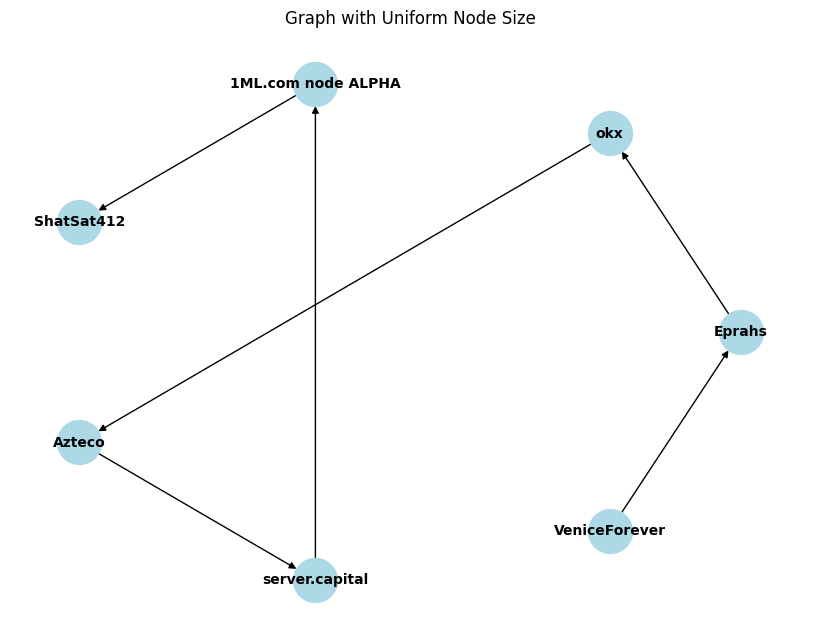

In [23]:

import networkx as nx
import matplotlib.pyplot as plt

# edges list construction
edges_df = final[["source-alias", "destination-alias"]]

G = nx.from_pandas_edgelist(edges_df, "source-alias", "destination-alias", create_using=nx.DiGraph())

plt.figure(figsize=(8, 6))
pos = nx.circular_layout(G)
nx.draw(G, pos, with_labels=True, node_size=1000, node_color='lightblue', font_size=10, font_color='black', font_weight='bold', arrows=True)
plt.title("Graph with Uniform Node Size")
plt.show()


In [24]:
for i in nx.strongly_connected_components(G):
    print(i)

{'ShatSat412'}
{'1ML.com node ALPHA'}
{'server.capital'}
{'Azteco'}
{'okx'}
{'Eprahs'}
{'VeniceForever'}


In [25]:
final
final["amount"] = final["amount"].astype(float)
final["rate_fee"] = final["rate_fee"].astype(float)
final["base_fee"] = final["base_fee"].astype(float)
total_transaction_cost = sum(final["amount"] * final["rate_fee"] + final["base_fee"])
perc_cost = (total_transaction_cost * 100) / transaction_amount
print(f"Transacting {transaction_amount} sats costs {total_transaction_cost} ({perc_cost}% of transaction amount)")
print("Solver Status: ", results.solver[0]["System time"])

Transacting 100000 sats costs 4687.774311133034 (4.687774311133033% of transaction amount)
Solver Status:  114.57


/tmp/ipykernel_10651/2595053910.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final["amount"] = final["amount"].astype(float)
/tmp/ipykernel_10651/2595053910.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final["rate_fee"] = final["rate_fee"].astype(float)
/tmp/ipykernel_10651/2595053910.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pyda

In [26]:
#from collections import Counter
#results = [tuple(i) for i in DF_channels_pos[["source-alias", "destination-alias"]].to_numpy()]
#unwrap = [e for i in results for e in i]
#extremes = [j for j in unwrap if Counter(unwrap)[j] == 1]
#def return_source(l: list):
#    if l[0] in [i for i, j in results]:
#        return l[0]
#    else: 
#        return l[1]
#sequence = []        
#source = return_source(extremes)
#sequence.append(source)
#while len(sequence) <= len(results):
#    for i,j in results:
#        if i == sequence[-1]:
#            sequence.append(j)
#for i in sequence:
#    print("⬇️", i)